# 带有一个隐含层的神经网络

**目标：**
* 实现带有一个隐含层的二分类神经网络
* 使用非线性激活函数，比如 tanh
* 计算交叉熵
* 实现前向、反向传播

## 1 - Packages

导入以下packages

- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [sklearn](http://scikit-learn.org/stable/) provides simple and efficient tools for data mining and data analysis. 
- [matplotlib](http://matplotlib.org) is a library for plotting graphs in Python.

In [1]:
# import package
import sys
sys.path.append("..")

from data.read_titanic_data import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model


%matplotlib inline

np.random.seed(1)

载入数据
* x - 泰坦尼克号乘员的基本信息（已格式化处理）(pclass, sex, age, sibsp, parch, fare, carbin, embarked)
* y - 是否在灾难中生存 1 是， 0 否

In [2]:
X, Y = load_dataset()

In [3]:
print("shape of X is:", X.shape)
print("shape of Y is:", Y.shape)
print("train sample count:", X.shape[1])

shape of X is: (8, 891)
shape of Y is: (1, 891)
train sample count: 891


## 3 - 简单的逻辑回归

在构建网络之前，我们用 sklearn 的 api 先看一下使用逻辑回归的表现。

In [4]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T, Y.ravel())

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

输出在原数据上的表现结果：

In [5]:
LR_predictions = clf.predict(X.T)
Y_r = Y.ravel()

Y_r = np.array(Y_r, dtype=float)
LR_predictions = np.array(LR_predictions, dtype=float)

print("正确率：%f " % float( (np.dot(Y_r, LR_predictions) + np.dot(1-Y_r, 1-LR_predictions)) / Y.shape[1]* 100 ) + "%" )

正确率：81.257015 %


## 4 - 神经网络模型

**数学模型：**

对于一个 example:
$$z^{[1](i)} = W^{[1]}x^{(i)} + b^{[1]}$$
$$a^{[1]{i}} = tanh(z^{[1](i)})$$
$$z^{[2](i)} = W^{[2]}a^{[1](i)} + b^{[2]}$$
$$\hat{y}^{(i)} = \sigma(z^{[2](i)})$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}$$

cost J:

$$J = -\frac{1}{m}\sum_{i=1}^{m}(y^{(i)}log(\hat{y}^{(i)}) + (1-y^{(i)})log(1-\hat{y}^{(i)}))$$

构造神经网络的一般方法如下：
* 定义网络结构
* 初始化参数
* 循环
    - 实现前向传播
    - 计算 loss
    - 实现反向传播，得到梯度
    - 更新参数

### 4.1 - 定义网络结构

* n_x: 输入层的 size
* n_h: 隐含层的 size
* n_y: 输出层的 size

这里直接设置隐含层的大小为 4

In [6]:
def layer_sizes(X, Y, h_size=4):
    n_x = X.shape[0]
    n_h = h_size
    n_y = Y.shape[0]
    return (n_x, n_h, n_y)

In [7]:
n_x, n_h, n_y = layer_sizes(X, Y)
print("input layer size:", n_x)
print("hidden layer size:", n_h)
print("output layer size:", n_y)

input layer size: 8
hidden layer size: 4
output layer size: 1


### 4.2 - 初始化模型参数

* 使用 `np.random.randn(a, b)` * 0.01 初始化 w
* 使用 `np.zeros(a, b)` 初始化b

In [8]:
def initialize_parameters(n_x, n_h, n_y):
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    return {
        'W1': W1,
        "b1": b1,
        "W2": W2,
        'b2': b2
    }

In [9]:
params = initialize_parameters(n_x, n_h, n_y)
print(params)

{'W1': array([[ 0.01624345, -0.00611756, -0.00528172, -0.01072969,  0.00865408,
        -0.02301539,  0.01744812, -0.00761207],
       [ 0.00319039, -0.0024937 ,  0.01462108, -0.02060141, -0.00322417,
        -0.00384054,  0.01133769, -0.01099891],
       [-0.00172428, -0.00877858,  0.00042214,  0.00582815, -0.01100619,
         0.01144724,  0.00901591,  0.00502494],
       [ 0.00900856, -0.00683728, -0.0012289 , -0.00935769, -0.00267888,
         0.00530355, -0.00691661, -0.00396754]]), 'b1': array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.]]), 'W2': array([[-0.00687173, -0.00845206, -0.00671246, -0.00012665]]), 'b2': array([[ 0.]])}


### 4.3 循环

实现前向传播

In [10]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    return A2, {
        "Z1": Z1,
        "A1": A1,
        "Z2": Z2,
        "A2": A2
    }


In [15]:
A2, cache = forward_propagation(X, params)

### 4.4 - 计算 cost

cost J:

$$J = -\frac{1}{m}\sum_{i=1}^{m}(y^{(i)}log(\hat{y}^{(i)}) + (1-y^{(i)})log(1-\hat{y}^{(i)}))$$

In [12]:
def compute_cost(A2, Y, parameters):
    m = Y.shape[1]
    
    cost = - np.sum((Y * np.log(A2) + (1-Y) * np.log(1-A2))) / m
    cost = np.squeeze(cost)
    return cost

In [13]:
cost = compute_cost(A2, Y, params)
print(cost)

0.692851101616


实现**反向传播**

公式：

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m}dZ^{[2]}A^{[1]T}$$
$$db^{[2]} = \frac{1}{m}np.sum(dZ^{[2]}, axis=1, keepdims=True)$$
$$dZ^{[1]} = W^{[2]T}dZ^{[2]} * g^{[1]‘}(Z^{[1]})$$
$$dW^{[1]} = \frac{1}{m}dZ^{[1]}X^{T}$$
$$db^{[1]} = \frac{1}{m}np.sum(dZ^{[1]}, axis=1, keepdims=True)$$

提示：

$g(z) = tanh(z)$ 则 $g^{'}(z) = 1-g(z)^{2}$

In [18]:
def backward_propagation(parameters, cache, X, Y):
    W1 = parameters['W1']  # (4, 8)  # 4 是隐藏层 8 是输入层
    b1 = parameters['b1']  # (4, 1)
    W2 = parameters['W2']  # (1, 4)
    b2 = parameters['b2']  # (1, 1)
    
    A1 = cache['A1']   # (4, m)   隐含层有 4 个神经元
    A2 = cache['A2']   # (1, m)
    
    m = X.shape[1]
    
    dZ2 = A2 - Y     # (1, m)
    dW2 = np.dot(dZ2, A1.T) / m  # (1,m) (m, 4) => (1, 4)
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m  # (1, 1)
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))  # (4, m)
    dW1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m
    
    grads = {
        "dW1": dW1,
        "db1": db1,
        "dW2": dW2,
        "db2": db2
    }
    return grads

In [19]:
grads = backward_propagation(params, cache, X, Y)
print(grads)

{'dW1': array([[ -2.45852001e-03,  -5.90025648e-04,  -2.84518850e-02,
         -2.80816839e-04,  -3.09748431e-05,  -6.94213574e-03,
          2.42848539e-04,  -9.82403831e-04],
       [ -2.83712237e-03,  -1.37818836e-04,  -2.64039069e-02,
         -6.63764358e-04,  -8.59592004e-05,   1.49406489e-02,
          1.06702627e-03,  -8.24210223e-04],
       [ -2.75702537e-03,  -5.19596892e-04,  -3.11381138e-02,
         -4.73405597e-04,  -1.00288580e-04,  -4.54274083e-03,
          4.78098778e-04,  -1.03613105e-03],
       [ -5.21436321e-05,  -6.20899612e-06,  -5.51038047e-04,
         -1.03716909e-05,  -1.93832620e-06,   8.01840331e-05,
          1.44355479e-05,  -1.75938639e-05]]), 'db1': array([[ -8.31847037e-04],
       [ -7.80336273e-04],
       [ -8.92931314e-04],
       [ -1.56904766e-05]]), 'dW2': array([[-0.02456693,  0.05969793, -0.00578336, -0.01034217]]), 'db2': array([[ 0.11596756]])}


**更新参数**

In [20]:
def update_parameters(parameters, grads, learning_rate=1.2):
    return {
        "W1": parameters['W1'] - learning_rate * grads['dW1'],
        "W2": parameters['W2'] - learning_rate * grads['dW2'],
        "b1": parameters['b1'] - learning_rate * grads['db1'],
        "b2": parameters['b2'] - learning_rate * grads['db2']
    }

In [21]:
params = update_parameters(params, grads)
print(params)

{'W1': array([[ 0.01919368, -0.00540953,  0.02886054, -0.01039271,  0.00869125,
        -0.01468482,  0.0171567 , -0.00643318],
       [ 0.00659494, -0.00232832,  0.04630577, -0.01980489, -0.00312102,
        -0.02176932,  0.01005726, -0.01000986],
       [ 0.00158415, -0.00815507,  0.03778787,  0.00639624, -0.01088585,
         0.01689853,  0.00844219,  0.0062683 ],
       [ 0.00907113, -0.00682983, -0.00056766, -0.00934525, -0.00267655,
         0.00520733, -0.00693393, -0.00394642]]), 'W2': array([[ 0.02260859, -0.08008957,  0.00022757,  0.01228396]]), 'b1': array([[  9.98216444e-04],
       [  9.36403528e-04],
       [  1.07151758e-03],
       [  1.88285720e-05]]), 'b2': array([[-0.13916107]])}


### 4.5 - 把以上函数合并成 nn_model


In [59]:
def nn_model(X, Y, n_h, learning_rate=1.2, num_iterations=10000, print_cost=False):
    params = initialize_parameters(X.shape[0], n_h, Y.shape[0])
    
    costs = []
    
    for i in range(num_iterations):
        A2, cache = forward_propagation(X, params)
        cost = compute_cost(A2, Y, params)
        
        grads = backward_propagation(params, cache, X, Y)
        params = update_parameters(params, grads, learning_rate)
        
        if i % 1000 == 0:
            costs.append(cost)
            
        if print_cost and i % 1000 == 0:
            print("迭代 %d 次后，cost 为: %f" % (i, cost))
            #print("acc rate: ", acc_rate(Y, predict(params, X)))
            
    
    return {
        "costs": costs,
        "params": params,
        "learning_rate": learning_rate
    }

迭代 0 次后，cost 为: 0.692695
迭代 1000 次后，cost 为: 0.621028
迭代 2000 次后，cost 为: 0.590368
迭代 3000 次后，cost 为: 0.730769
迭代 4000 次后，cost 为: 0.517416
迭代 5000 次后，cost 为: 0.587090
迭代 6000 次后，cost 为: 0.486834
迭代 7000 次后，cost 为: 0.479767
迭代 8000 次后，cost 为: 0.484890
迭代 9000 次后，cost 为: 0.583099
迭代 10000 次后，cost 为: 0.481738
迭代 11000 次后，cost 为: 0.543006
迭代 12000 次后，cost 为: 0.476928
迭代 13000 次后，cost 为: 0.487576
迭代 14000 次后，cost 为: 0.479813
迭代 15000 次后，cost 为: 0.466912
迭代 16000 次后，cost 为: 0.468784
迭代 17000 次后，cost 为: 0.465089
迭代 18000 次后，cost 为: 0.477808
迭代 19000 次后，cost 为: 0.456670
迭代 20000 次后，cost 为: 0.459562
迭代 21000 次后，cost 为: 0.492295
迭代 22000 次后，cost 为: 0.464334
迭代 23000 次后，cost 为: 0.451908
迭代 24000 次后，cost 为: 0.491173
迭代 25000 次后，cost 为: 0.488596
迭代 26000 次后，cost 为: 0.479101
迭代 27000 次后，cost 为: 0.542308
迭代 28000 次后，cost 为: 0.452921
迭代 29000 次后，cost 为: 0.497068
迭代 30000 次后，cost 为: 0.520297
迭代 31000 次后，cost 为: 0.454775
迭代 32000 次后，cost 为: 0.468666
迭代 33000 次后，cost 为: 0.459425
迭代 34000 次后，cost 为: 0.44027

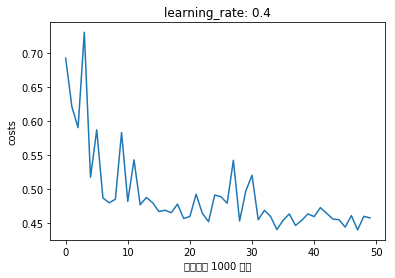

In [62]:
res = nn_model(X, Y, 4, learning_rate=0.4, num_iterations=50000, print_cost=True)

plt.plot(res['costs'])
plt.ylabel("costs")
plt.xlabel("次数（每 1000 次）")
plt.title("learning_rate: " + str(res['learning_rate']))
plt.show()

### 4.6 计算正确率 （在原数据上）

实现 predict

In [52]:
def predict(params, X):
    A2, cache = forward_propagation(X, params)
    A2= A2.ravel()
    Y_predictions = np.zeros(A2.size)
    Y_predictions[A2 > 0.5] = 1
    return Y_predictions   # (m, )

def acc_rate(Y, Y_predictions):
    return np.sum(((Y * Y_predictions) + (1 - Y) * (1 - Y_predictions))) / Y.size * 100

In [53]:
print("acc rate: ", acc_rate(Y, predict(res['params'], X)))

acc rate:  79.5735129068


### 4.7 - 调整隐藏层的神经元数量

Accuracy for 2 hidden units: 61.61616161616161 %
Accuracy for 4 hidden units: 79.7979797979798 %
Accuracy for 6 hidden units: 79.34904601571269 %
Accuracy for 8 hidden units: 81.81818181818183 %
Accuracy for 10 hidden units: 80.47138047138047 %
Accuracy for 15 hidden units: 83.72615039281706 %
Accuracy for 20 hidden units: 86.08305274971941 %


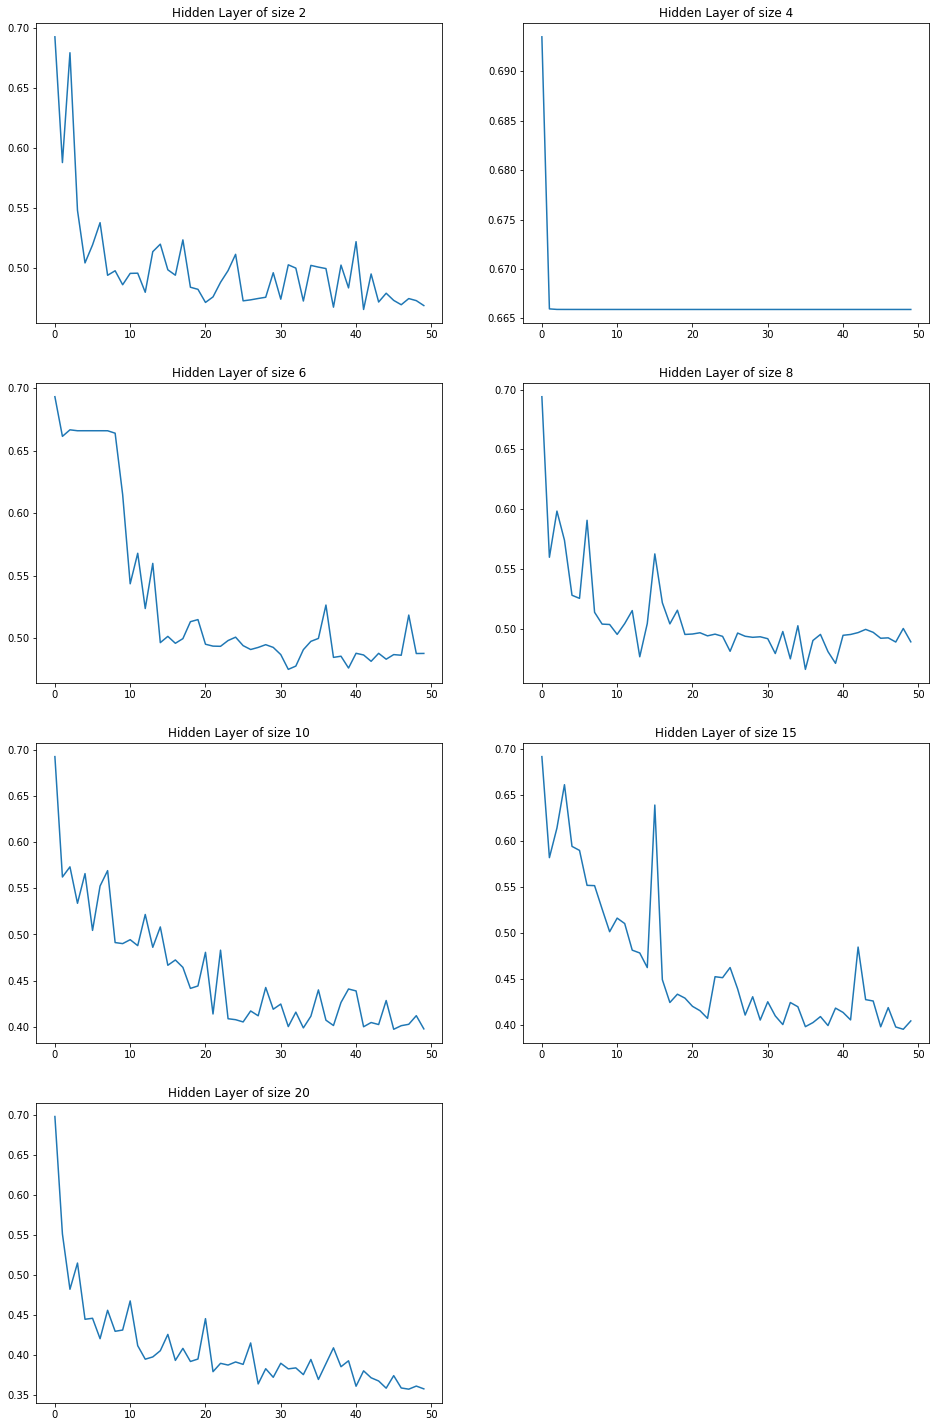

In [65]:
plt.figure(figsize=(16, 32))
hidden_layer_size=[2, 4, 6, 8, 10, 15, 20]
for i, n_h, in enumerate(hidden_layer_size):
    plt.subplot(5, 2, i + 1)
    plt.title('Hidden Layer of size %d' % n_h)
    plt.plot(res['costs'])
    res = nn_model(X, Y, n_h, learning_rate=0.4, num_iterations = 50000)
    #plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    accuracy = acc_rate(Y, predict(res['params'], X))
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

plt.show()
